# Example: Properties

#### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import dxtb

#### Functions

In [7]:
# https://wiki.fysik.dtu.dk/ase/_modules/ase/vibrations/vibrations.html#Vibrations.fold
def fold(
    frequencies,
    intensities,
    start=800.0,
    end=4000.0,
    npts=None,
    width=4.0,
    type="Gaussian",
    normalize=True,
):
    """
    Fold frequencies and intensities within the given range
    and folding method (Gaussian/Lorentzian).
    The energy unit is cm^-1.
    normalize=True ensures the integral over the peaks to give the
    intensity.
    """

    lctype = type.lower()
    assert lctype in ["gaussian", "lorentzian"]

    if not npts:
        npts = int((end - start) / width * 10 + 1)

    prefactor = 1
    if lctype == "lorentzian":
        intensities = intensities * width * np.pi / 2.0
        if normalize:
            prefactor = 2.0 / width / np.pi
    else:
        sigma = width / 2.0 / np.sqrt(2.0 * np.log(2.0))
        if normalize:
            prefactor = 1.0 / sigma / np.sqrt(2 * np.pi)

    # Make array with spectrum data
    spectrum = np.empty(npts)
    energies = np.linspace(start, end, npts)
    for i, energy in enumerate(energies):
        energies[i] = energy
        if lctype == "lorentzian":
            spectrum[i] = (
                intensities
                * 0.5
                * width
                / np.pi
                / ((frequencies - energy) ** 2 + 0.25 * width**2)
            ).sum()
        else:
            spectrum[i] = (
                intensities * np.exp(-((frequencies - energy) ** 2) / 2.0 / sigma**2)
            ).sum()
    return [energies, prefactor * spectrum]


In [8]:
# from CCCBDB (calculated frequencies and vibrational properties for H2O)
HF_FREQ = np.array([3944.0, 3811.0, 1800.0])
HF_INTS = np.array([9.123e00, 4.7e-02, 7.989e01])

# xtb h2o/coord --gfn 1 --hess
REF_FREQ = np.array([1480.0601, 3643.9749, 3747.3581])
REF_INTS = np.array([232.8048, 45.4997, 45.5097])


In [9]:
numbers = torch.tensor([8, 1, 1])
positions = torch.tensor(
    [
        [+0.00000000000000, +0.00000000000000, -0.74288549752983],
        [-1.43472674945442, +0.00000000000000, +0.37144274876492],
        [+1.43472674945442, +0.00000000000000, +0.37144274876492],
    ]
)
charge = torch.tensor(0.0)

# position gradient for intensities
positions.requires_grad_(True)

# dipole moment requires electric field
field_vector = torch.tensor([0.0, 0.0, 0.0])
ef = dxtb.external.field.new_efield(field_vector)

calc = dxtb.Calculator(numbers, dxtb.GFN1_XTB, interaction=[ef])
freqs, ints = calc.ir_spectrum(numbers, positions, chrg=charge)

freqs, ints = freqs.detach().numpy(), ints.detach().numpy()


iter  energy                   energy change  P norm change   charge change  
-----------------------------------------------------------------------------
  1   -5.8041028976440430E+00   1.005300E+01  3.457257E+00    9.763781E-01
  2   -5.8052034378051758E+00   1.100540E-03  5.829924E-02    4.791563E-02
  3   -5.8052477836608887E+00   4.434586E-05  1.415263E-02    1.172066E-02
  4   -5.8052482604980469E+00   4.768372E-07  5.090873E-04    4.213747E-04
  5   -5.8052496910095215E+00   1.430511E-06  5.510674E-05    4.573305E-05
  6   -5.8052487373352051E+00   9.536743E-07  3.311093E-05    2.724701E-05
  7   -5.8052501678466797E+00   1.430511E-06  5.060859E-06    4.471171E-06
-----------------------------------------------------------------------------
**********************Energy**********************

Contribution                 Energy in a.u.    
--------------------------------------------------
Halogen                      0.0000000000000000
Repulsion                    0.0367647185

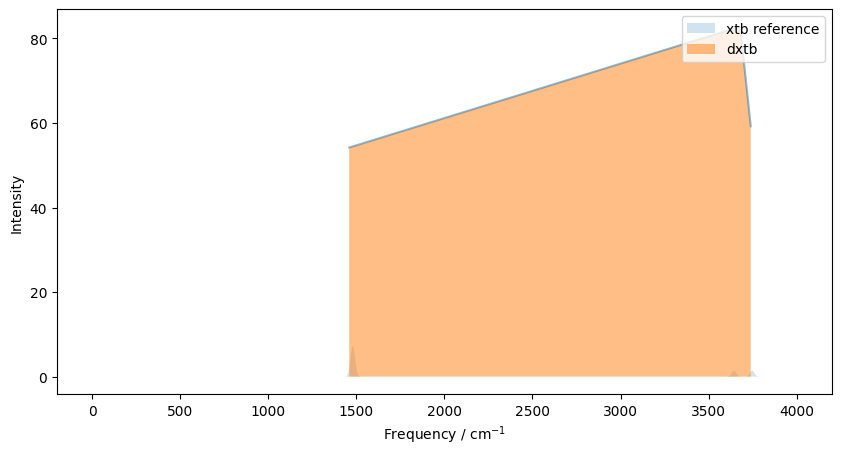

In [10]:
ref_freq, ref_ints = fold(
    REF_FREQ, REF_INTS, start=0.0, end=4000.0, width=30.0
)

dxtb_freq, dxtb_ints = fold(
    freqs, ints, start=0.0, end=4000.0, width=30.0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot experimental data.
ax.plot(ref_freq, ref_ints, alpha=0.5)
ax.fill_between(ref_freq, ref_ints, label="xtb reference", alpha=0.2)

# Plot xtb data.
ax.plot(freqs, ints, alpha=0.5)
ax.fill_between(freqs, ints, label="dxtb", alpha=0.5)

plt.xlabel("Frequency / cm$^{-1}$")
plt.ylabel("Intensity")
plt.legend(loc="upper right")
plt.show()
